In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf
from pandas import TimeGrouper
from pandas import concat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import PCA
from matplotlib.mlab import PCA as PCAmat
from sklearn.preprocessing import scale, StandardScaler
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

###


import sklearn.cross_validation
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score,auc,precision_recall_curve
from sklearn.cluster import KMeans
from sklearn import svm,tree
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.utils import shuffle
from datetime import datetime, date, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from numpy.random import vonmises
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler


%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", Depre

# Datasets import

In [2]:
# Dataset to start
trainingTable1= pd.read_csv('BATADAL_dataset03.csv')

In [3]:
# Dataset to optimize
trainingTable2= pd.read_csv('BATADAL_dataset04.csv')

In [4]:
# Dataset to test 
testTable= pd.read_csv('BATADAL_test_dataset.csv')

# Preprocessing
    - Fix TrainingTable2 columns header
    - Check for null instances
    - Creation of DATETIME as new index for all the tables
    - Remove all the information that is not needed and keep only the sensors info
    - Creation of training data table



In [5]:
#Fixing trainingTable2 columns header
trainingTable2.head(n=10)
trainingTable2.columns = trainingTable2.columns.str.replace('\s+', '')

In [6]:
# Check for nulls
trainingTable1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 45 columns):
DATETIME    8761 non-null object
L_T1        8761 non-null float64
L_T2        8761 non-null float64
L_T3        8761 non-null float64
L_T4        8761 non-null float64
L_T5        8761 non-null float64
L_T6        8761 non-null float64
L_T7        8761 non-null float64
F_PU1       8761 non-null float64
S_PU1       8761 non-null int64
F_PU2       8761 non-null float64
S_PU2       8761 non-null int64
F_PU3       8761 non-null int64
S_PU3       8761 non-null int64
F_PU4       8761 non-null float64
S_PU4       8761 non-null int64
F_PU5       8761 non-null int64
S_PU5       8761 non-null int64
F_PU6       8761 non-null float64
S_PU6       8761 non-null int64
F_PU7       8761 non-null float64
S_PU7       8761 non-null int64
F_PU8       8761 non-null float64
S_PU8       8761 non-null int64
F_PU9       8761 non-null int64
S_PU9       8761 non-null int64
F_PU10      8761 non-null float64


In [7]:
# Converting index
trainingTable1['DATETIME'] = pd.to_datetime(trainingTable1['DATETIME'],format = '%d/%m/%y %H')
trainingTable2['DATETIME'] = pd.to_datetime(trainingTable2['DATETIME'],format = '%d/%m/%y %H')
testTable['DATETIME'] = pd.to_datetime(testTable['DATETIME'],format = '%d/%m/%y %H')
trainingTable1= trainingTable1.set_index('DATETIME')
trainingTable2= trainingTable2.set_index('DATETIME')
testTable= testTable.set_index('DATETIME')

In [8]:
## drop all the columns that present nan in adfuller test
dataToPlot = trainingTable1.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])

dataToPlot2 = trainingTable2.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])


In [9]:
testToPlot = testTable.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','F_PU11','S_PU10','S_PU11','S_V2'])


In [10]:
# creates one single table for all the training data
frames = [dataToPlot,dataToPlot2]

trainingTable = pd.concat(frames)

# Visualisation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10279d390>,
      dtype=object)

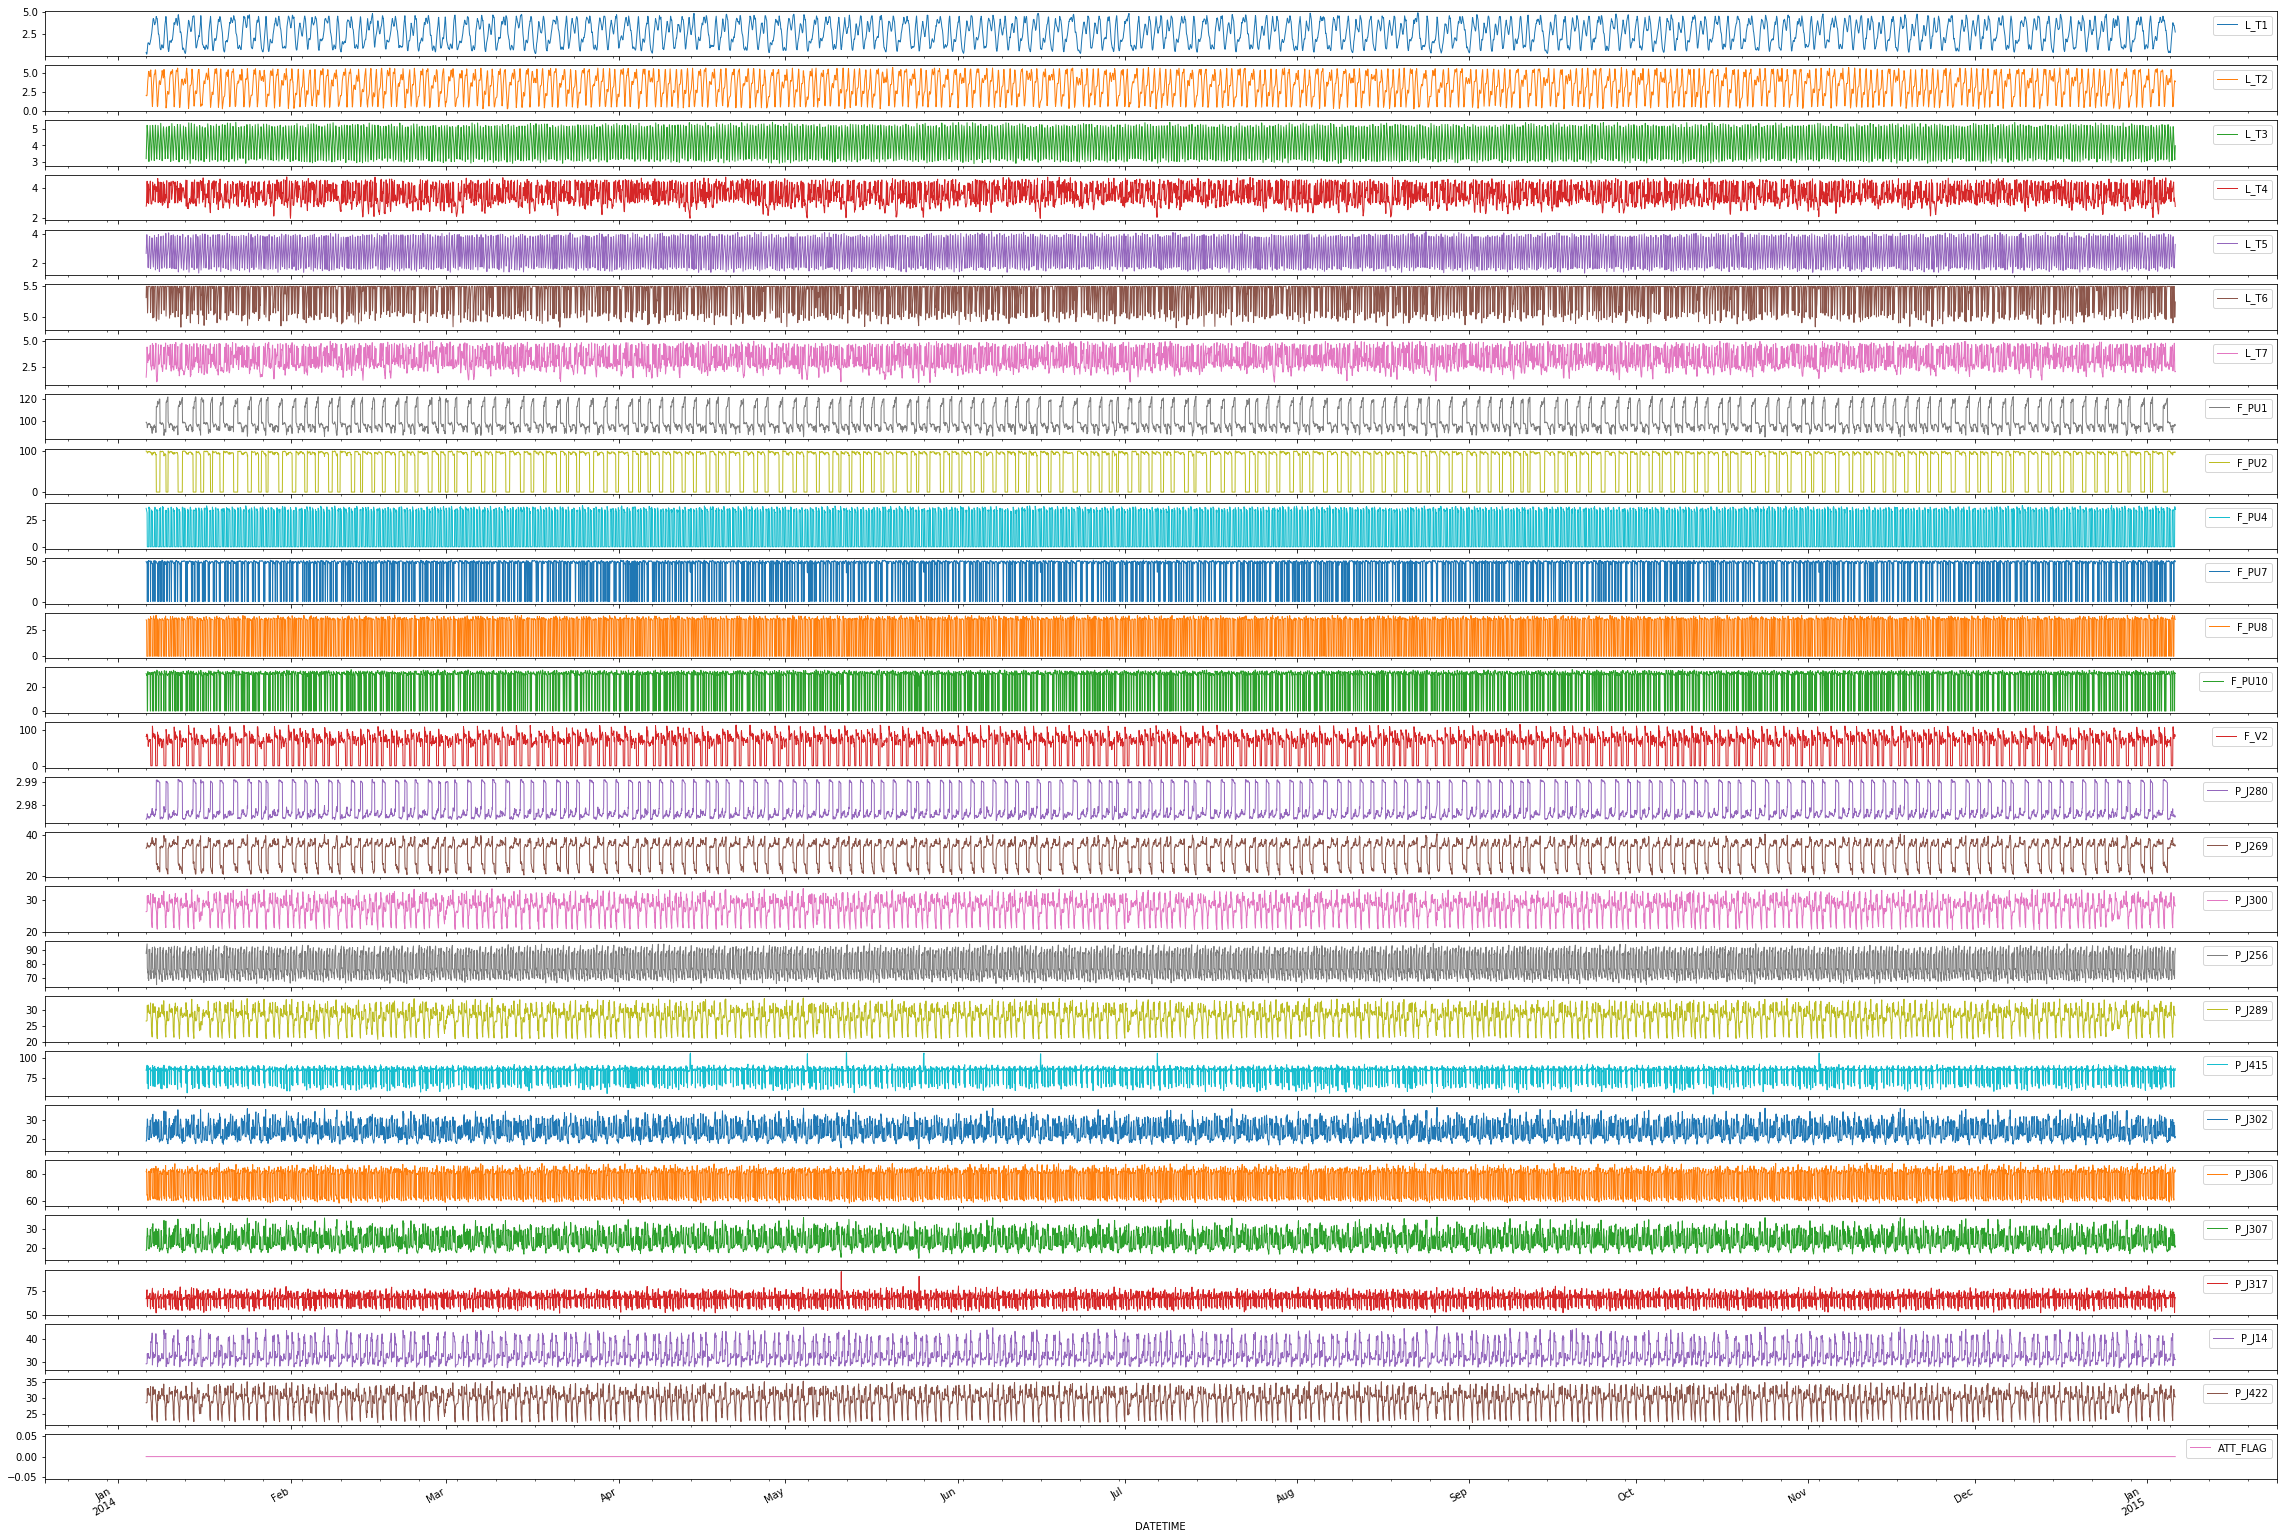

In [11]:
dataToPlot.plot(subplots=True,linewidth=1,kind='line',figsize=(40,30),sharex=True,sharey=False)

### Correlations between time series

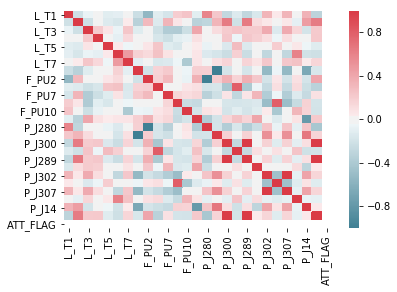

In [12]:
sns.heatmap(dataToPlot.corr(method='spearman'), mask=np.zeros_like(dataToPlot.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))

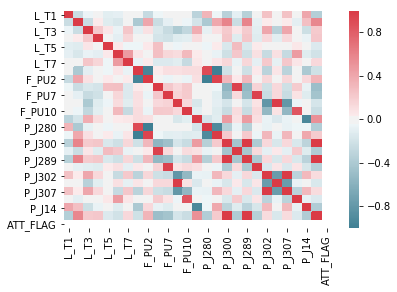

In [13]:
sns.heatmap(dataToPlot.corr(method='pearson'), mask=np.zeros_like(dataToPlot.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [14]:
trainingTable1['P_J422']

DATETIME
2014-01-06 00:00:00    28.487471
2014-01-06 01:00:00    28.454256
2014-01-06 02:00:00    28.454538
2014-01-06 03:00:00    28.549952
2014-01-06 04:00:00    28.674263
2014-01-06 05:00:00    32.849392
2014-01-06 06:00:00    30.908869
2014-01-06 07:00:00    30.800341
2014-01-06 08:00:00    31.039440
2014-01-06 09:00:00    32.882660
2014-01-06 10:00:00    31.481596
2014-01-06 11:00:00    31.658922
2014-01-06 12:00:00    31.321112
2014-01-06 13:00:00    31.074152
2014-01-06 14:00:00    30.927252
2014-01-06 15:00:00    30.892244
2014-01-06 16:00:00    30.770679
2014-01-06 17:00:00    31.247364
2014-01-06 18:00:00    31.522209
2014-01-06 19:00:00    33.494816
2014-01-06 20:00:00    29.684786
2014-01-06 21:00:00    29.166368
2014-01-06 22:00:00    28.662035
2014-01-06 23:00:00    25.280834
2014-01-07 00:00:00    24.465290
2014-01-07 01:00:00    23.752186
2014-01-07 02:00:00    23.102018
2014-01-07 03:00:00    27.970068
2014-01-07 04:00:00    29.829569
2014-01-07 05:00:00    33.322083
 

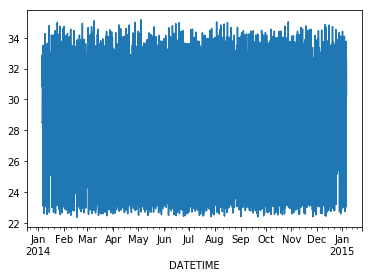

In [15]:
trainingTable1['P_J422'].plot()

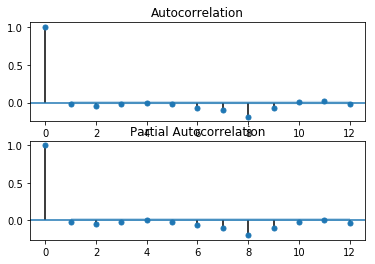

In [16]:
chg_temp = trainingTable1['F_V2'].diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF 
plot_acf(chg_temp, lags=12, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=12, ax=axes[1])
plt.show()

In [17]:
# test if sensors are random walk 

columnsSize = dataToPlot.columns.size - 1
columns = list(range(columnsSize))
print(columns)
results = [adfuller(dataToPlot.iloc[:,column]) for column in columns]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [18]:
count = 0 
colNames = trainingTable1.columns.values.tolist()
for result in results:
    print('==================================')
    print('Column %s' %colNames[count])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    count = count + 1

Column L_T1
ADF Statistic: -20.615633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T2
ADF Statistic: -18.612726
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T3
ADF Statistic: -14.375782
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T4
ADF Statistic: -16.582866
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T5
ADF Statistic: -18.509403
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T6
ADF Statistic: -18.364822
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T7
ADF Statistic: -17.489711
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column F_PU1
ADF Statistic: -27.596471
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column S_PU1
ADF Statistic: -27.586431
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column F

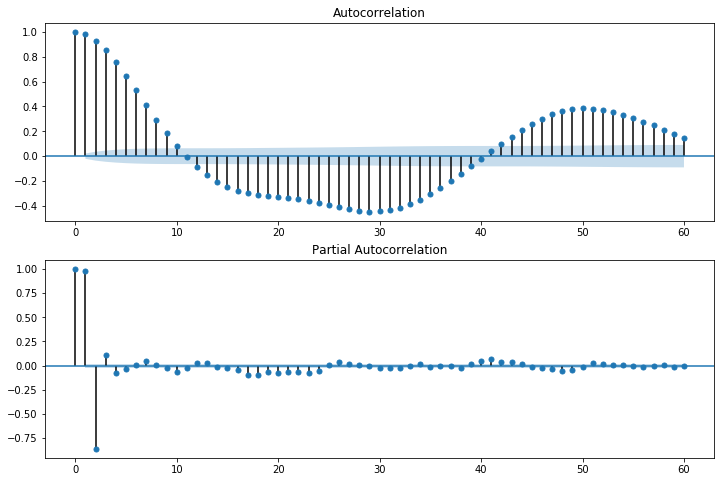

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trainingTable1['L_T1'], lags=60, ax=ax1,alpha=0.05)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trainingTable1['L_T1'], lags=60, ax=ax2,alpha=0.05)
plt.show()

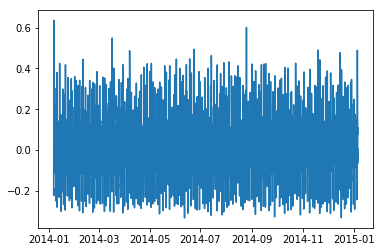

In [20]:
plt.plot(trainingTable1['L_T1'].pct_change())

In [21]:
print(acf(trainingTable1['F_PU1']))

[ 1.          0.88842832  0.7779471   0.67365269  0.5712454   0.46768877
  0.36262662  0.25456042  0.14871147  0.05212462 -0.02901983 -0.10335739
 -0.16900937 -0.22121146 -0.25921387 -0.28397782 -0.29464691 -0.29730426
 -0.29925067 -0.30631712 -0.31379347 -0.32224706 -0.3315234  -0.33890313
 -0.34713295 -0.35686197 -0.3637945  -0.36427606 -0.3605646  -0.3511266
 -0.33958139 -0.32250248 -0.29992968 -0.26948004 -0.23002061 -0.18601731
 -0.14002935 -0.09269629 -0.04445145  0.00326373  0.05444767]


L_T1


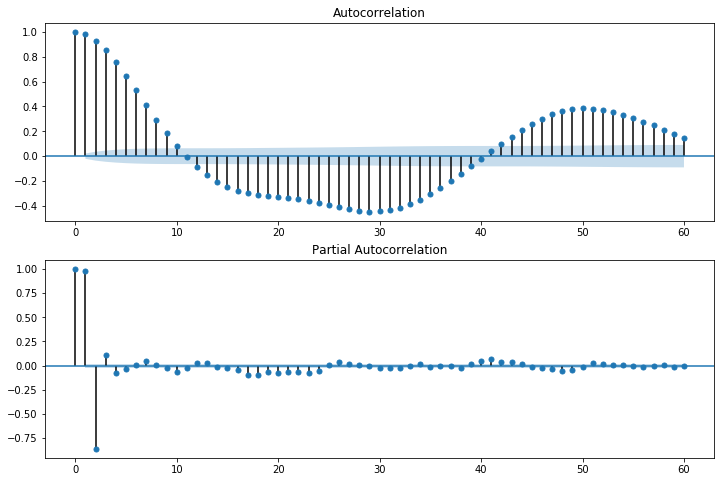

L_T2


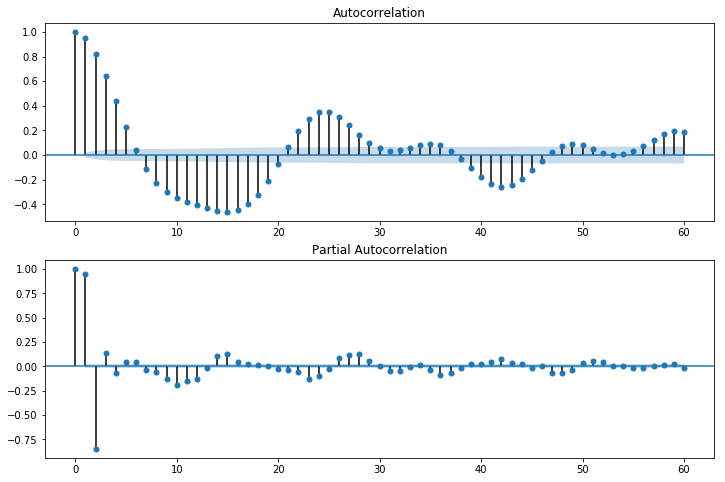

L_T3


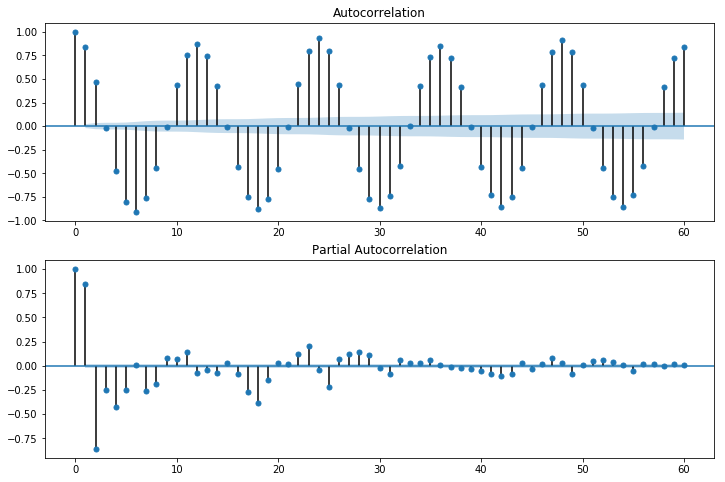

L_T4


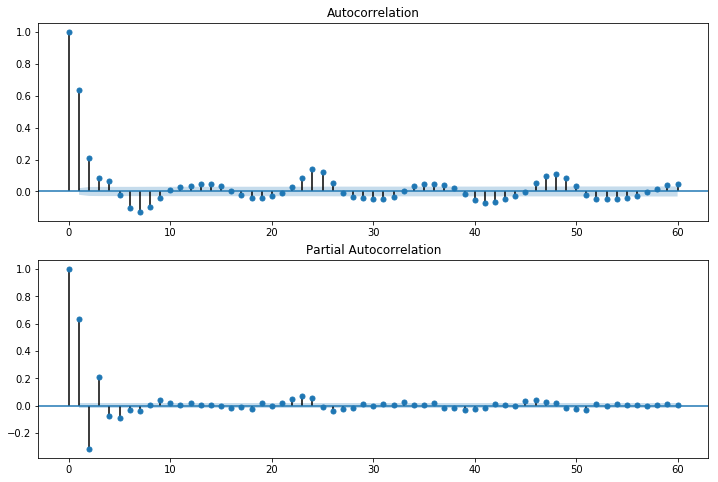

L_T5


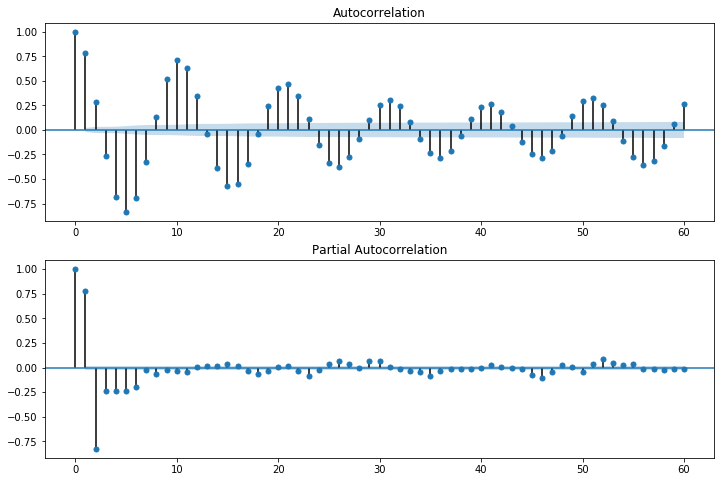

L_T6


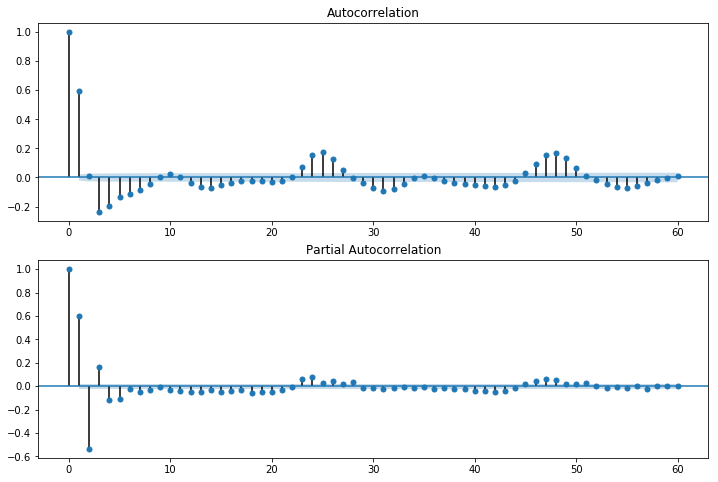

L_T7


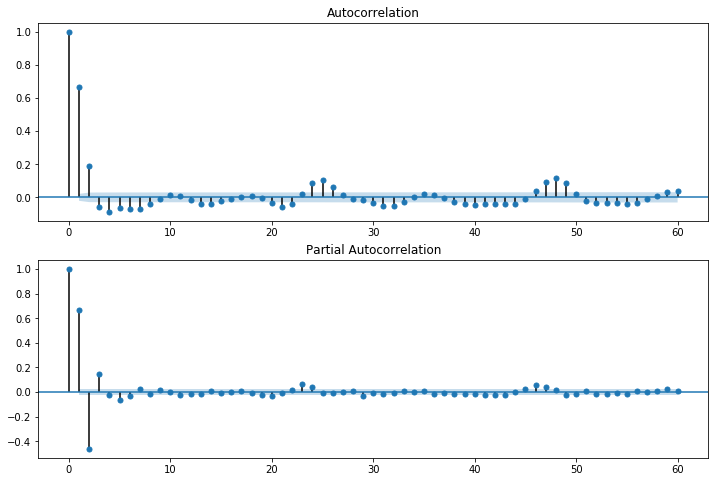

F_PU1


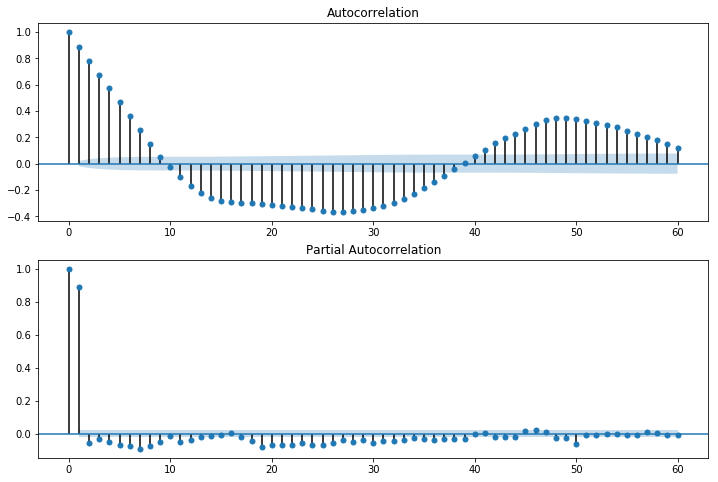

F_PU2


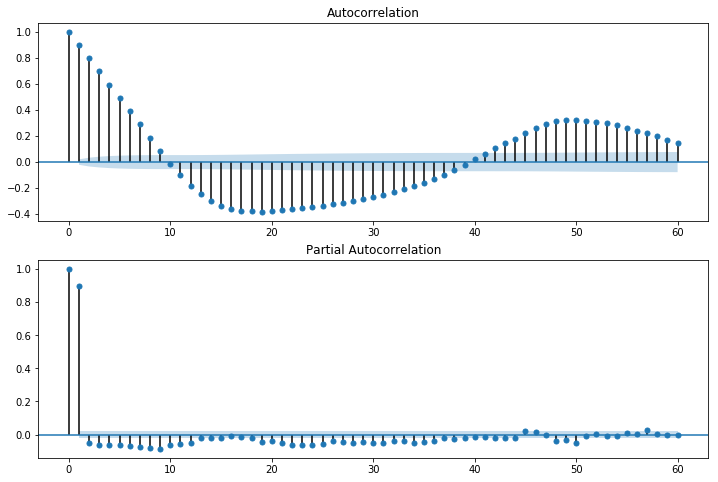

F_PU4


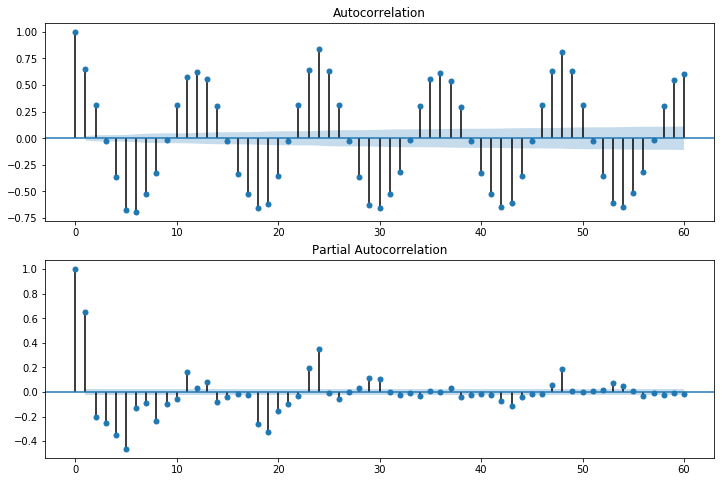

F_PU7


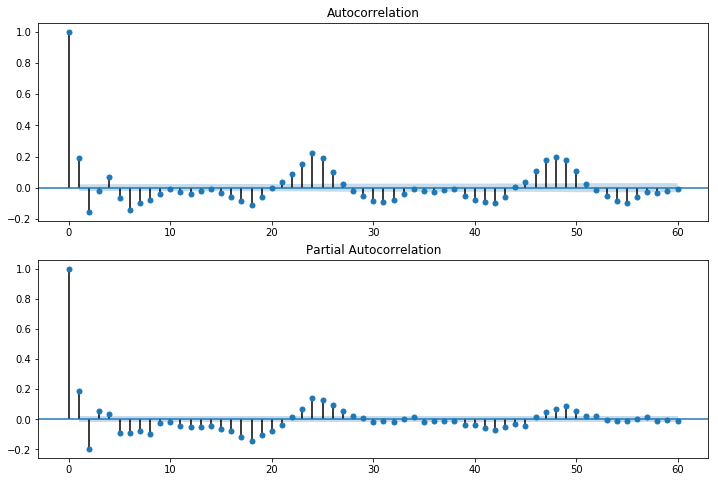

F_PU8


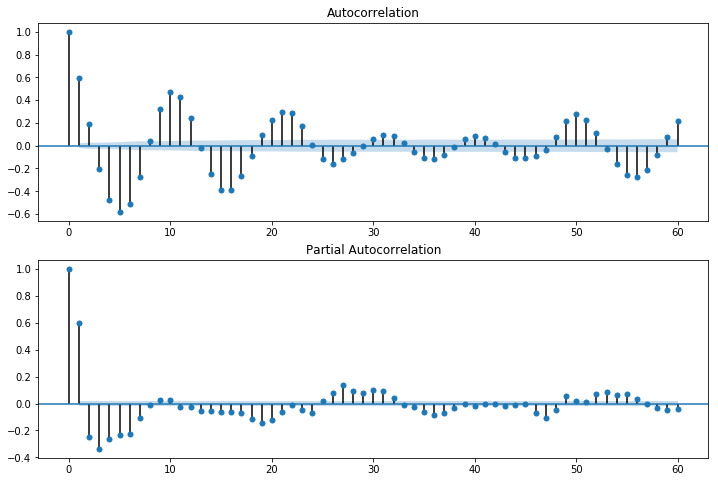

F_PU10


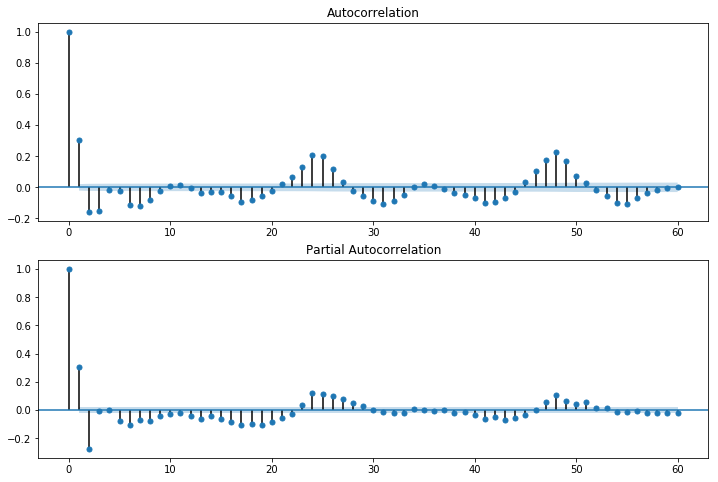

F_V2


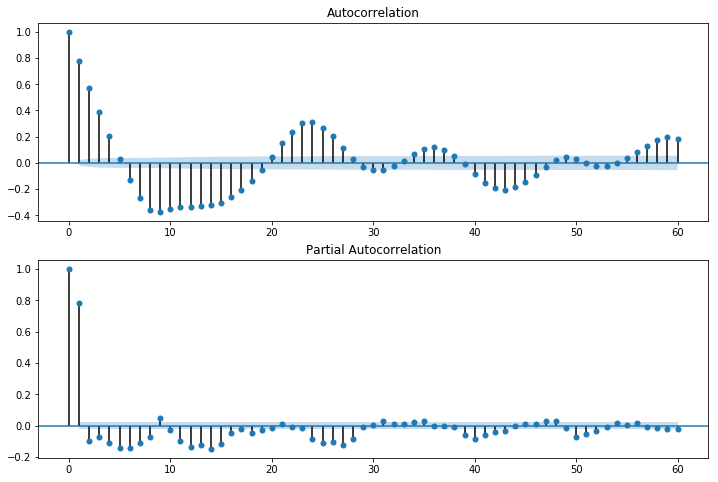

P_J280


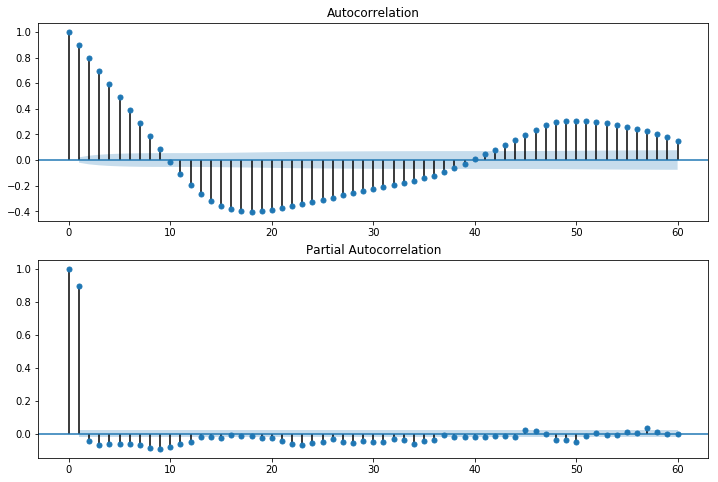

P_J269


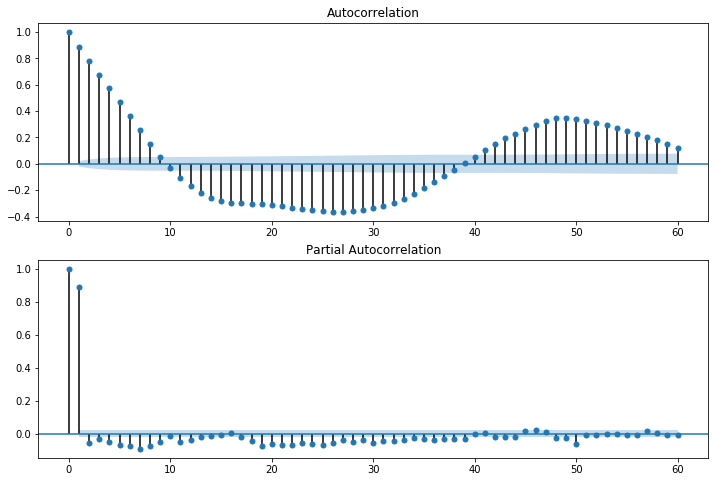

P_J300


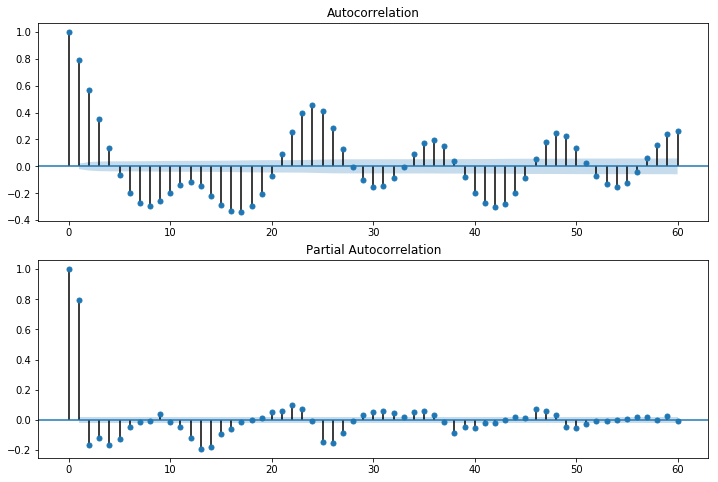

P_J256


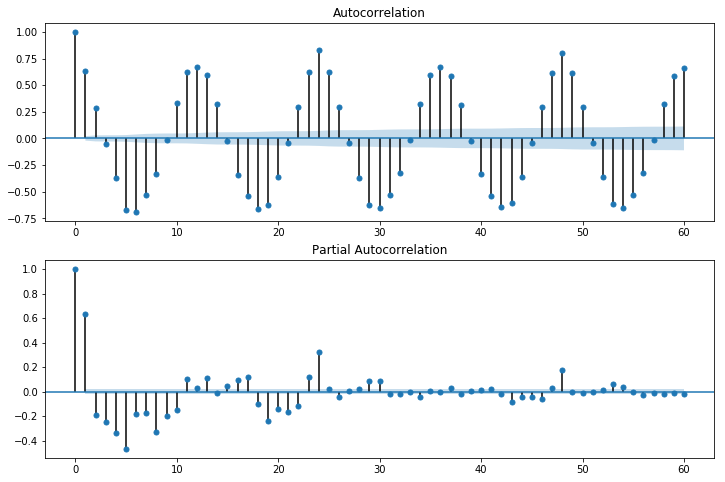

P_J289


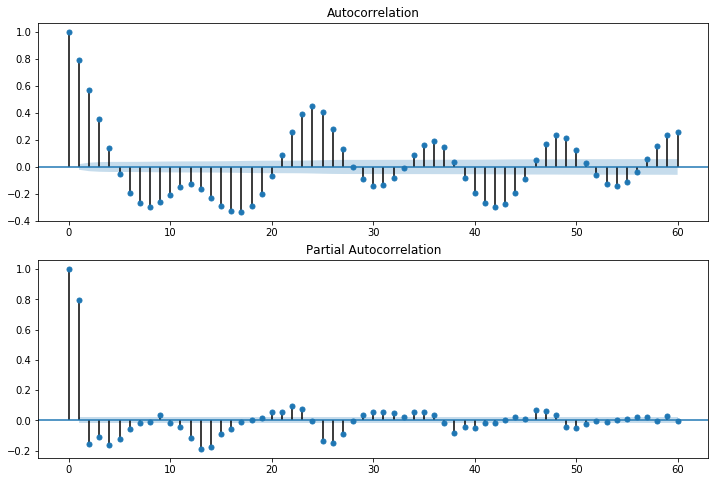

P_J415


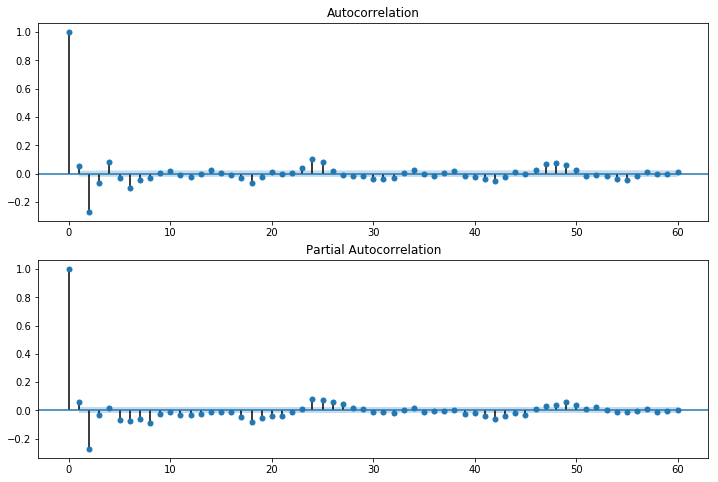

P_J302


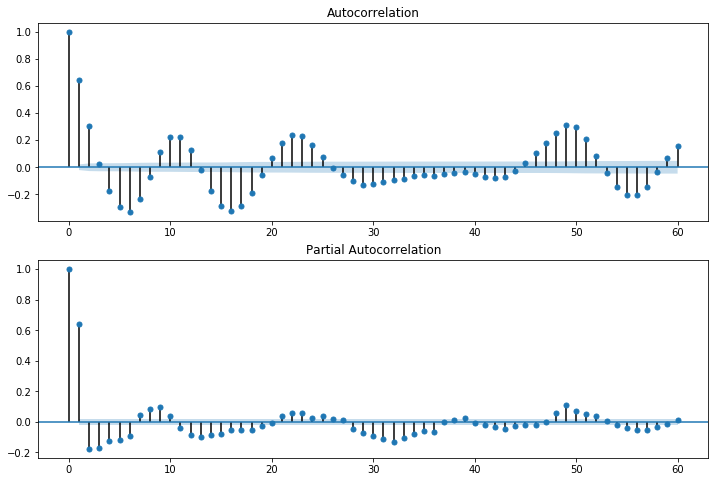

P_J306


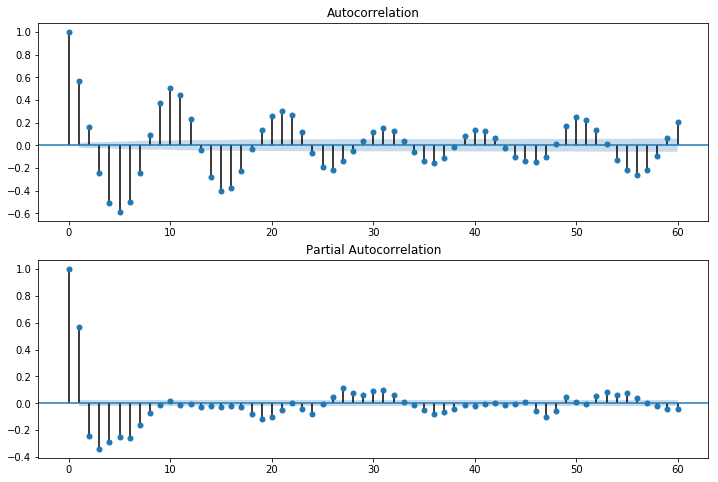

P_J307


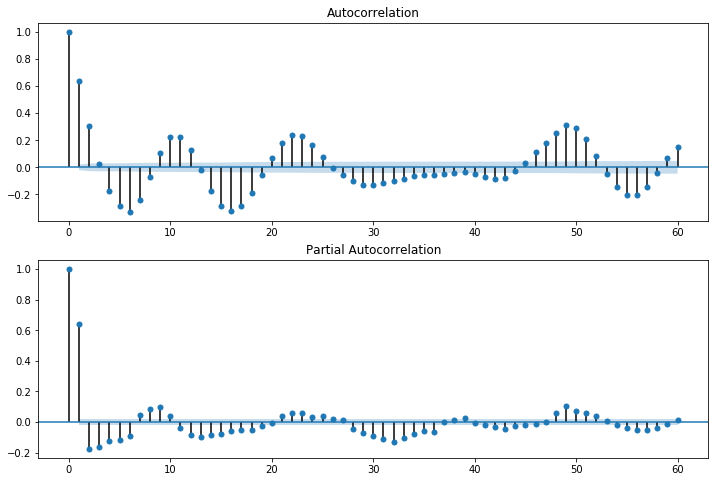

P_J317


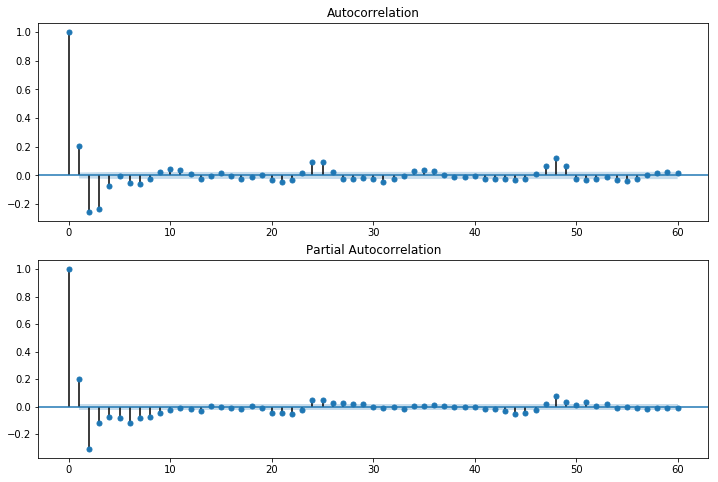

P_J14


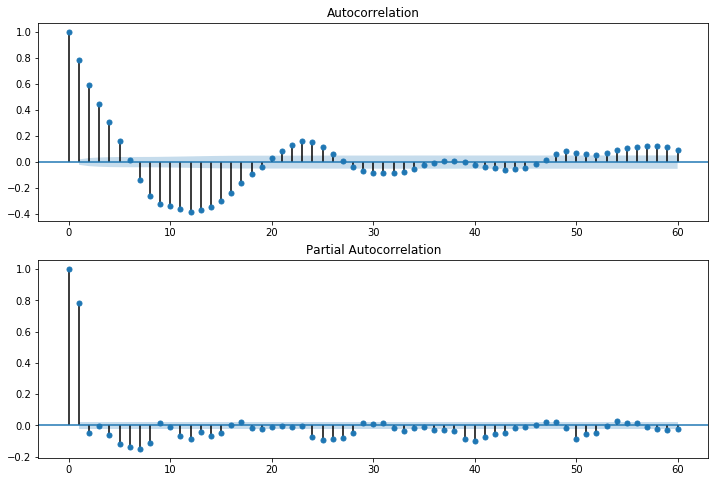

P_J422


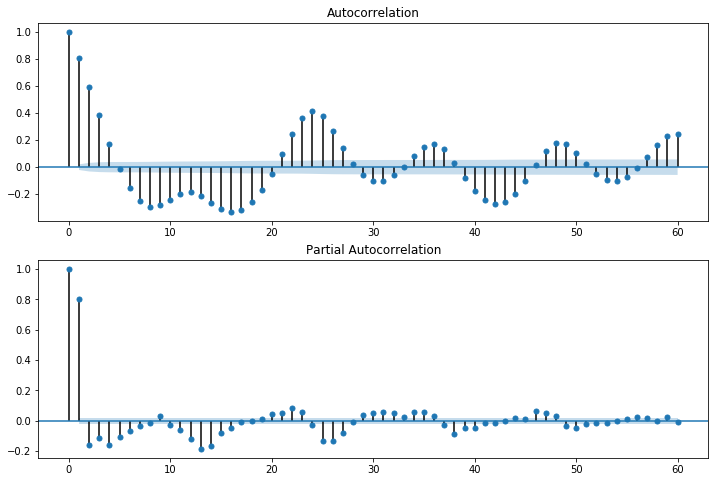

In [22]:
for column in columns:
    print(dataToPlot.iloc[:,column].name)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(dataToPlot.iloc[:,column], lags=60, ax=ax1,alpha=0.05)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(dataToPlot.iloc[:,column], lags=60, ax=ax2,alpha=0.05)
    plt.show()

series = dataToPlot.iloc[:,1]
one_year = series['14']
groups = one_year.groupby(TimeGrouper('D'))
months = concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,31)
months.boxplot()
plt.show()

series = dataToPlot.iloc[:,1]
one_year = series['2014']
groups = one_year.groupby(TimeGrouper('M'))
months = concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.show()

# parameters are determined based o training data

In [23]:
columnsSize = dataToPlot.columns.size
columns = list(range(columnsSize-1))
#columns = list(range(4))
for column in columns:
    bestAIC = 9999999
    bestAR = -1
    bestMA=-1
    for p in list(range(2)):
        for q in list(range(2)):
            model = ARMA(dataToPlot.iloc[:,column],order=(p,q)).fit(transparams=True)
            if model.aic < bestAIC:
                bestAIC = model.aic
                bestAR = p
                bestMA = q
    print('-------------------')
    print(dataToPlot.iloc[:,column].name)
    print('AIC: {:.2f}'.format(bestAIC))
    print('AR parameter {}'.format(bestAR))
    print('MA parameter {}'.format(bestMA))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


-------------------
L_T1
AIC: -7752.46
AR parameter 1
MA parameter 1
-------------------
L_T2
AIC: 4485.76
AR parameter 1
MA parameter 1
-------------------
L_T3
AIC: 1561.88
AR parameter 1
MA parameter 1


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-------------------
L_T4
AIC: 8307.28
AR parameter 1
MA parameter 1
-------------------
L_T5
AIC: 6505.37
AR parameter 1
MA parameter 1
-------------------
L_T6
AIC: -11783.81
AR parameter 1
MA parameter 1
-------------------
L_T7
AIC: 14436.16
AR parameter 1
MA parameter 1
-------------------
F_PU1
AIC: 51633.37
AR parameter 1
MA parameter 1
-------------------
F_PU2
AIC: 75956.45
AR parameter 1
MA parameter 1
-------------------
F_PU4
AIC: 69437.37
AR parameter 1
MA parameter 1
-------------------
F_PU7
AIC: 74774.74
AR parameter 1
MA parameter 1
-------------------
F_PU8
AIC: 70797.06
AR parameter 1
MA parameter 1
-------------------
F_PU10
AIC: 67212.38
AR parameter 1
MA parameter 1
-------------------
F_V2
AIC: 79372.16
AR parameter 1
MA parameter 1
-------------------
P_J280
AIC: -78036.00
AR parameter 1
MA parameter 1
-------------------
P_J269
AIC: 41217.86
AR parameter 1
MA parameter 1
-------------------
P_J300
AIC: 33611.64
AR parameter 1
MA parameter 1
-------------------
P

# Residuals

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                   L_T2   No. Observations:                 8761
Model:                     ARMA(5, 1)   Log Likelihood                 161.819
Method:                       css-mle   S.D. of innovations              0.237
Date:                Mon, 04 Jun 2018   AIC                           -307.639
Time:                        23:40:35   BIC                           -251.014
Sample:                    01-06-2014   HQIC                          -288.345
                         - 01-06-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2856      0.018    179.998      0.000       3.250       3.321
ar.L1.L_T2     2.7921      0.015    182.077      0.000       2.762       2.822
ar.L2.L_T2    -2.8680      0.038    -75.488      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                 0
count  8761.000000
mean     -0.000085
std       0.237848
min      -1.236621
25%      -0.155128
50%      -0.008780
75%       0.131766
max       1.109981


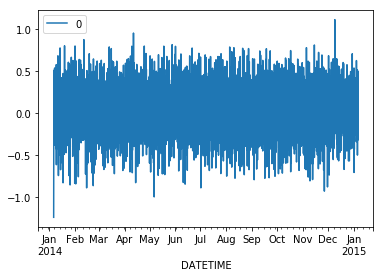

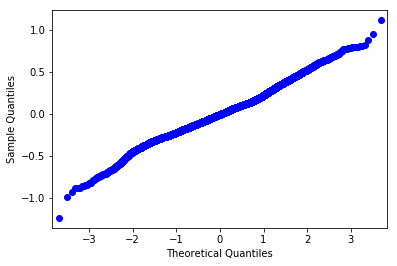

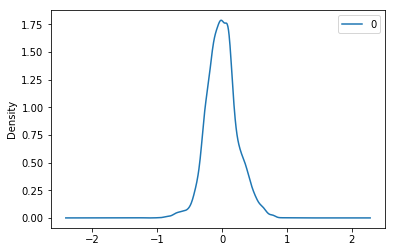

In [24]:
# fit model
model = ARMA(dataToPlot.iloc[:,1], order=(5,1))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

residuals2 = np.array(model_fit.resid)
sm.qqplot(residuals2)

residuals.plot(kind='kde')
print(residuals.describe())

In [25]:
## TODO Report
#In this case : 
##The results show that indeed there is no bias in the prediction (an approximately zero mean in the residuals).



In [26]:
y_train = dataToPlot.iloc[:,-1]
x_train = dataToPlot.iloc[:,:-1]
x_test = dataToPlot2.iloc[:,:-1]
y_test =  dataToPlot2.iloc[:,-1]

In [27]:
dataToPlot.describe()

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,F_PU4,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,...,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.0
mean,2.676905,3.285748,4.201820,3.568129,2.748205,5.370437,3.302672,100.926032,69.464357,14.555019,...,79.411082,27.776600,82.737615,24.453808,74.459039,24.362250,67.921632,33.755911,29.453266,0.0
std,1.202940,1.468621,0.678465,0.539656,0.735162,0.177459,0.828849,10.048618,42.239742,17.042785,...,8.461924,2.720291,7.502937,4.416089,9.974357,4.438203,5.321227,4.232716,2.658146,0.0
min,0.320112,0.293876,2.882847,2.002133,1.293241,4.824605,1.054194,85.495201,0.000000,0.000000,...,65.059624,20.690191,54.757198,14.797167,58.325397,14.541955,51.697071,27.649677,22.370066,0.0
25%,1.650647,2.131776,3.623394,3.139640,2.123508,5.248147,2.631062,94.342598,0.000000,0.000000,...,71.978676,26.674088,83.912292,20.516289,62.949253,20.409576,66.718307,30.668709,28.432796,0.0
50%,2.798855,3.498371,4.240439,3.574840,2.758198,5.500000,3.252838,96.729073,94.075195,0.000000,...,75.879807,28.110842,85.219460,22.969397,81.176102,22.856150,68.807007,32.222023,29.834288,0.0
75%,3.754744,4.570782,4.793697,4.009889,3.372392,5.500000,3.986883,112.294952,96.614708,34.030491,...,88.221329,29.553995,86.416519,28.457081,82.673698,28.382421,71.218712,38.134647,31.275637,0.0
max,4.871329,5.663802,5.433022,4.690665,4.162726,5.500000,4.999618,122.705627,100.140671,38.296165,...,94.961258,33.763836,105.951820,36.325947,89.053986,36.325947,96.180450,45.388145,35.161724,0.0


# Performance

In [28]:
## TODO : for all columns , only need to substitute 1 for column
#columnsT = columns[:,-1]
columnsTSize = x_test.columns.size
columnsT = range(columnsTSize)
for column in columnsT:
    history = [x for x in x_train.iloc[:,column]]
    predictions = list()
    errors=  list()
    residuals = []
    model = ARMA(history,order=(4,1))
    thrs=(max(history) - min(history))/10
    FP = 0
    TP = 0
    FN = 0
    TN = 0
    for i in range(0,len(x_test.iloc[:,column]),5):
        if i >= 2089 :
            break
        model = ARMA(history,order=(4,1))
        model_fit= model.fit()
        forecast= model_fit.forecast(steps = 5)
        #predict
        results = forecast[0][:5]
        predictions.append(results)
        
        # observation
        for result in range(len(results)):
            obs = history[result+i]
            history.append(obs)
            print('>Predicted=%.3f, Expected=%.3f' % (results[result], obs))
            predictions.append(obs)
            diff = abs(obs - results[result])
            errors.append(obs)
            residuals.append(diff)
            if diff>=thrs:
                print("ANOMALY")
                if y_test[i]==1:
                    TP+=1
                else:
                    FP+=1
                #sumThrs = sumThrs + diff
            #print('ALERT ANOMALY ?')
    # report performance
    mse = mean_squared_error(x_test.iloc[:,column], predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


>Predicted=2.606, Expected=0.510
ANOMALY
>Predicted=2.511, Expected=0.413
ANOMALY
>Predicted=2.454, Expected=0.320
ANOMALY
>Predicted=2.429, Expected=0.333
ANOMALY
>Predicted=2.427, Expected=0.483
ANOMALY
>Predicted=0.702, Expected=0.791
>Predicted=0.962, Expected=1.187
>Predicted=1.246, Expected=1.420
>Predicted=1.543, Expected=1.535
>Predicted=1.842, Expected=1.577


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.660, Expected=1.559
>Predicted=1.794, Expected=1.481
>Predicted=1.964, Expected=1.465
ANOMALY
>Predicted=2.159, Expected=1.484
ANOMALY
>Predicted=2.365, Expected=1.384
ANOMALY
>Predicted=1.359, Expected=1.352
>Predicted=1.424, Expected=1.455
>Predicted=1.562, Expected=1.532
>Predicted=1.753, Expected=1.663
>Predicted=1.978, Expected=1.839


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.050, Expected=1.904
>Predicted=2.282, Expected=2.114
>Predicted=2.521, Expected=2.286
>Predicted=2.758, Expected=2.417
>Predicted=2.984, Expected=2.607
>Predicted=2.810, Expected=2.878
>Predicted=3.008, Expected=3.236
>Predicted=3.195, Expected=3.538
>Predicted=3.364, Expected=3.711
>Predicted=3.512, Expected=3.970
ANOMALY
>Predicted=4.185, Expected=4.170
>Predicted=4.336, Expected=4.231
>Predicted=4.427, Expected=4.162
>Predicted=4.463, Expected=4.139
>Predicted=4.454, Expected=3.943
ANOMALY
>Predicted=3.742, Expected=3.785
>Predicted=3.565, Expected=3.634
>Predicted=3.414, Expected=3.545
>Predicted=3.284, Expected=3.666
>Predicted=3.173, Expected=3.709
ANOMALY
>Predicted=3.707, Expected=3.755
>Predicted=3.671, Expected=3.820
>Predicted=3.610, Expected=4.056
>Predicted=3.529, Expected=4.421
ANOMALY
>Predicted=3.434, Expected=4.460
ANOMALY
>Predicted=4.386, Expected=4.309
>Predicted=4.254, Expected=4.216
>Predicted=4.084, Expected=4.228
>Predicted=3.889, Expected=4.190
>Pr

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.543, Expected=2.470
>Predicted=2.547, Expected=2.302
>Predicted=2.528, Expected=2.054
ANOMALY
>Predicted=2.494, Expected=1.671
ANOMALY
>Predicted=2.450, Expected=1.316
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.060, Expected=0.988
>Predicted=0.902, Expected=0.942
>Predicted=0.828, Expected=0.834
>Predicted=0.824, Expected=0.809
>Predicted=0.878, Expected=0.810


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.865, Expected=0.983
>Predicted=0.969, Expected=1.183
>Predicted=1.110, Expected=1.319
>Predicted=1.280, Expected=1.353
>Predicted=1.469, Expected=1.319
>Predicted=1.332, Expected=1.188
>Predicted=1.401, Expected=1.080
>Predicted=1.517, Expected=1.015
ANOMALY
>Predicted=1.667, Expected=1.009
ANOMALY
>Predicted=1.840, Expected=0.994
ANOMALY
>Predicted=1.050, Expected=1.155
>Predicted=1.176, Expected=1.445
>Predicted=1.357, Expected=1.884
ANOMALY
>Predicted=1.576, Expected=2.453
ANOMALY
>Predicted=1.817, Expected=2.910
ANOMALY
>Predicted=3.281, Expected=3.261
>Predicted=3.577, Expected=3.507
>Predicted=3.806, Expected=3.695
>Predicted=3.973, Expected=3.880
>Predicted=4.087, Expected=4.108
>Predicted=4.279, Expected=4.454
>Predicted=4.381, Expected=4.415
>Predicted=4.422, Expected=4.027
>Predicted=4.410, Expected=3.638
ANOMALY
>Predicted=4.355, Expected=3.254
ANOMALY
>Predicted=2.941, Expected=2.885
>Predicted=2.700, Expected=2.514
>Predicted=2.524, Expected=2.102
>Predicted=2

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.145, Expected=1.231
>Predicted=1.415, Expected=1.578
>Predicted=1.690, Expected=1.776
>Predicted=1.961, Expected=1.790
>Predicted=2.222, Expected=1.760
ANOMALY
>Predicted=1.782, Expected=1.745
>Predicted=1.860, Expected=1.754
>Predicted=1.981, Expected=1.625
>Predicted=2.133, Expected=1.604
ANOMALY
>Predicted=2.302, Expected=1.740
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.928, Expected=1.795
>Predicted=2.138, Expected=1.880
>Predicted=2.354, Expected=1.856
ANOMALY
>Predicted=2.569, Expected=1.881
ANOMALY
>Predicted=2.774, Expected=2.047
ANOMALY
>Predicted=2.251, Expected=2.341
>Predicted=2.464, Expected=2.504
>Predicted=2.674, Expected=2.748
>Predicted=2.874, Expected=2.982
>Predicted=3.059, Expected=3.283
>Predicted=3.547, Expected=3.620
>Predicted=3.756, Expected=3.771
>Predicted=3.912, Expected=3.622
>Predicted=4.019, Expected=3.575
>Predicted=4.081, Expected=3.601
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.627, Expected=3.749
>Predicted=3.639, Expected=3.868
>Predicted=3.635, Expected=3.988
>Predicted=3.616, Expected=4.072
ANOMALY
>Predicted=3.584, Expected=4.249
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.367, Expected=4.166
>Predicted=4.410, Expected=4.001
>Predicted=4.386, Expected=3.886
ANOMALY
>Predicted=4.309, Expected=3.749
ANOMALY
>Predicted=4.190, Expected=3.607
ANOMALY
>Predicted=3.462, Expected=3.493
>Predicted=3.318, Expected=3.656
>Predicted=3.177, Expected=4.055
ANOMALY
>Predicted=3.041, Expected=4.583
ANOMALY
>Predicted=2.913, Expected=4.651
ANOMALY
>Predicted=4.567, Expected=4.473
>Predicted=4.408, Expected=4.311
>Predicted=4.203, Expected=4.098
>Predicted=3.970, Expected=3.885
>Predicted=3.719, Expected=3.688
>Predicted=3.479, Expected=3.338
>Predicted=3.262, Expected=2.954
>Predicted=3.043, Expected=2.693
>Predicted=2.830, Expected=2.721
>Predicted=2.628, Expected=2.753


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.748, Expected=2.738
>Predicted=2.710, Expected=2.577
>Predicted=2.647, Expected=2.419
>Predicted=2.568, Expected=2.102
ANOMALY
>Predicted=2.481, Expected=1.765
ANOMALY
>Predicted=1.497, Expected=1.512
>Predicted=1.305, Expected=1.161
>Predicted=1.184, Expected=0.932
>Predicted=1.124, Expected=0.838
>Predicted=1.114, Expected=0.894
>Predicted=1.000, Expected=0.940
>Predicted=1.132, Expected=0.994
>Predicted=1.281, Expected=0.901
>Predicted=1.440, Expected=0.768
ANOMALY
>Predicted=1.606, Expected=0.681
ANOMALY
>Predicted=0.681, Expected=0.622
>Predicted=0.760, Expected=0.570
>Predicted=0.901, Expected=0.488
>Predicted=1.088, Expected=0.446
ANOMALY
>Predicted=1.307, Expected=0.403
ANOMALY
>Predicted=0.455, Expected=0.486
>Predicted=0.600, Expected=0.640
>Predicted=0.816, Expected=0.905
>Predicted=1.082, Expected=1.290
>Predicted=1.381, Expected=1.595


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.893, Expected=1.772
>Predicted=2.189, Expected=2.078
>Predicted=2.477, Expected=2.332
>Predicted=2.749, Expected=2.545
>Predicted=3.001, Expected=2.814
>Predicted=3.072, Expected=3.155
>Predicted=3.302, Expected=3.398
>Predicted=3.501, Expected=3.701
>Predicted=3.666, Expected=4.038
>Predicted=3.797, Expected=3.965
>Predicted=3.841, Expected=3.941
>Predicted=3.729, Expected=3.746
>Predicted=3.637, Expected=3.568
>Predicted=3.560, Expected=3.395
>Predicted=3.496, Expected=3.302


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.239, Expected=3.221
>Predicted=3.191, Expected=3.017
>Predicted=3.153, Expected=2.866
>Predicted=3.121, Expected=2.799
>Predicted=3.093, Expected=2.823
>Predicted=2.860, Expected=2.881
>Predicted=2.894, Expected=3.019
>Predicted=2.922, Expected=3.324
>Predicted=2.943, Expected=3.608
ANOMALY
>Predicted=2.958, Expected=3.876
ANOMALY
>Predicted=4.058, Expected=4.152
>Predicted=4.153, Expected=4.305
>Predicted=4.175, Expected=4.475
>Predicted=4.138, Expected=4.437
>Predicted=4.055, Expected=4.455
>Predicted=4.420, Expected=4.531
>Predicted=4.325, Expected=4.533
>Predicted=4.181, Expected=4.425
>Predicted=4.001, Expected=3.986
>Predicted=3.797, Expected=3.550


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.158, Expected=3.202
>Predicted=2.817, Expected=2.800
>Predicted=2.526, Expected=2.430
>Predicted=2.281, Expected=1.966
>Predicted=2.081, Expected=1.499
ANOMALY
>Predicted=1.137, Expected=1.048
>Predicted=0.887, Expected=1.001
>Predicted=0.737, Expected=1.008
>Predicted=0.670, Expected=1.097
>Predicted=0.674, Expected=1.220
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.354, Expected=1.430
>Predicted=1.494, Expected=1.633
>Predicted=1.635, Expected=1.795
>Predicted=1.777, Expected=1.841
>Predicted=1.916, Expected=1.890


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.954, Expected=2.055
>Predicted=2.032, Expected=2.277
>Predicted=2.121, Expected=2.335
>Predicted=2.215, Expected=2.230
>Predicted=2.312, Expected=2.325


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.449, Expected=2.525
>Predicted=2.566, Expected=2.762
>Predicted=2.670, Expected=3.032
>Predicted=2.760, Expected=3.262
ANOMALY
>Predicted=2.836, Expected=3.609
ANOMALY
>Predicted=3.883, Expected=4.085
>Predicted=4.062, Expected=4.544
ANOMALY
>Predicted=4.156, Expected=4.241
>Predicted=4.178, Expected=3.692
ANOMALY
>Predicted=4.144, Expected=3.186
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.774, Expected=2.674
>Predicted=2.454, Expected=2.171
>Predicted=2.214, Expected=1.724
ANOMALY
>Predicted=2.041, Expected=1.422
ANOMALY
>Predicted=1.927, Expected=1.353
ANOMALY
>Predicted=1.368, Expected=1.343
>Predicted=1.426, Expected=1.290
>Predicted=1.515, Expected=1.198
>Predicted=1.624, Expected=1.041
ANOMALY
>Predicted=1.749, Expected=1.102
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.235, Expected=1.145
>Predicted=1.402, Expected=1.038
>Predicted=1.588, Expected=0.944
ANOMALY
>Predicted=1.784, Expected=0.889
ANOMALY
>Predicted=1.983, Expected=0.825
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=0.846, Expected=0.893
>Predicted=0.950, Expected=0.984
>Predicted=1.119, Expected=1.109
>Predicted=1.334, Expected=1.241
>Predicted=1.579, Expected=1.324
>Predicted=1.451, Expected=1.276
>Predicted=1.628, Expected=1.194
>Predicted=1.839, Expected=1.105
ANOMALY
>Predicted=2.072, Expected=1.046
ANOMALY
>Predicted=2.314, Expected=0.947
ANOMALY
>Predicted=0.951, Expected=0.894
>Predicted=1.058, Expected=0.888
>Predicted=1.247, Expected=1.075
>Predicted=1.494, Expected=1.370
>Predicted=1.777, Expected=1.770
>Predicted=2.176, Expected=2.299
>Predicted=2.562, Expected=2.792
>Predicted=2.916, Expected=3.073
>Predicted=3.235, Expected=3.374
>Predicted=3.513, Expected=3.568
>Predicted=3.725, Expected=3.754
>Predicted=3.857, Expected=3.937
>Predicted=3.964, Expected=4.201
>Predicted=4.045, Expected=4.470
>Predicted=4.100, Expected=4.085
>Predicted=3.670, Expected=3.756
>Predicted=3.334, Expected=3.383
>Predicted=3.083, Expected=2.958
>Predicted=2.903, Expected=2.531
>Predicted=2.782, E

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.907, Expected=1.824
>Predicted=1.967, Expected=1.856
>Predicted=2.078, Expected=1.953
>Predicted=2.223, Expected=2.089
>Predicted=2.390, Expected=2.246


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.419, Expected=2.502
>Predicted=2.601, Expected=2.848
>Predicted=2.781, Expected=3.097
>Predicted=2.955, Expected=3.310
>Predicted=3.115, Expected=3.466
>Predicted=3.589, Expected=3.590
>Predicted=3.683, Expected=3.843
>Predicted=3.752, Expected=4.146
>Predicted=3.795, Expected=4.074
>Predicted=3.815, Expected=4.006
>Predicted=3.933, Expected=3.889
>Predicted=3.853, Expected=4.022
>Predicted=3.767, Expected=4.204
>Predicted=3.676, Expected=4.437
ANOMALY
>Predicted=3.580, Expected=4.445
ANOMALY
>Predicted=4.371, Expected=4.298
>Predicted=4.252, Expected=4.190
>Predicted=4.103, Expected=4.009
>Predicted=3.935, Expected=3.758
>Predicted=3.754, Expected=3.593
>Predicted=3.438, Expected=3.423
>Predicted=3.283, Expected=3.240
>Predicted=3.128, Expected=3.117
>Predicted=2.978, Expected=2.941
>Predicted=2.835, Expected=2.665


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.414, Expected=2.237
>Predicted=2.211, Expected=1.842
>Predicted=2.053, Expected=1.499
ANOMALY
>Predicted=1.938, Expected=1.057
ANOMALY
>Predicted=1.859, Expected=0.841
ANOMALY
>Predicted=0.744, Expected=0.723
>Predicted=0.731, Expected=0.646
>Predicted=0.784, Expected=0.590
>Predicted=0.887, Expected=0.551
>Predicted=1.030, Expected=0.648
>Predicted=0.809, Expected=0.919
>Predicted=1.008, Expected=1.275
>Predicted=1.232, Expected=1.524
>Predicted=1.470, Expected=1.665
>Predicted=1.714, Expected=1.733


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.822, Expected=1.728
>Predicted=1.942, Expected=1.679
>Predicted=2.084, Expected=1.783
>Predicted=2.240, Expected=1.819
>Predicted=2.402, Expected=1.700
ANOMALY
>Predicted=1.635, Expected=1.654
>Predicted=1.647, Expected=1.751
>Predicted=1.723, Expected=1.869
>Predicted=1.847, Expected=1.997
>Predicted=2.005, Expected=2.169


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=2.354, Expected=2.434
>Predicted=2.542, Expected=2.799
>Predicted=2.723, Expected=3.005
>Predicted=2.894, Expected=3.142
>Predicted=3.050, Expected=3.360


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.553, Expected=3.565
>Predicted=3.703, Expected=3.810
>Predicted=3.809, Expected=3.704
>Predicted=3.875, Expected=3.694
>Predicted=3.906, Expected=3.832
>Predicted=3.946, Expected=4.082
>Predicted=4.011, Expected=4.325
>Predicted=4.027, Expected=4.322
>Predicted=4.003, Expected=4.231
>Predicted=3.946, Expected=4.106
>Predicted=3.964, Expected=3.964
>Predicted=3.810, Expected=3.845
>Predicted=3.651, Expected=3.785
>Predicted=3.490, Expected=3.816
>Predicted=3.330, Expected=3.991
ANOMALY
>Predicted=4.104, Expected=4.084
>Predicted=4.132, Expected=4.094
>Predicted=4.087, Expected=4.284
>Predicted=3.984, Expected=4.537
ANOMALY
>Predicted=3.839, Expected=4.462
ANOMALY
>Predicted=4.283, Expected=4.346
>Predicted=4.058, Expected=4.188
>Predicted=3.808, Expected=4.076
>Predicted=3.547, Expected=4.095
ANOMALY
>Predicted=3.285, Expected=4.053
ANOMALY
>Predicted=3.941, Expected=3.739
>Predicted=3.773, Expected=3.256
ANOMALY
>Predicted=3.567, Expected=2.837
ANOMALY
>Predicted=3.338, Ex

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=1.249, Expected=1.213
>Predicted=1.021, Expected=0.983
>Predicted=0.877, Expected=0.952
>Predicted=0.806, Expected=1.027
>Predicted=0.797, Expected=0.969
>Predicted=0.938, Expected=1.007
>Predicted=0.957, Expected=1.108
>Predicted=1.022, Expected=1.202
>Predicted=1.124, Expected=1.298
>Predicted=1.255, Expected=1.183
>Predicted=1.106, Expected=1.137
>Predicted=1.100, Expected=1.050
>Predicted=1.158, Expected=0.965
>Predicted=1.267, Expected=0.878
>Predicted=1.413, Expected=0.816
ANOMALY
>Predicted=0.839, Expected=0.850
>Predicted=0.940, Expected=1.057
>Predicted=1.101, Expected=1.432
>Predicted=1.306, Expected=1.773
ANOMALY
>Predicted=1.539, Expected=2.207
ANOMALY
>Predicted=2.606, Expected=2.658
>Predicted=2.948, Expected=2.968
>Predicted=3.231, Expected=3.181
>Predicted=3.459, Expected=3.404
>Predicted=3.637, Expected=3.731


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.001, Expected=3.953
>Predicted=4.192, Expected=4.231
>Predicted=4.310, Expected=4.469
>Predicted=4.365, Expected=4.367
>Predicted=4.367, Expected=4.318
>Predicted=4.252, Expected=4.313
>Predicted=4.162, Expected=4.366
>Predicted=4.048, Expected=4.188
>Predicted=3.918, Expected=3.993
>Predicted=3.776, Expected=3.786


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=3.585, Expected=3.624
>Predicted=3.393, Expected=3.452
>Predicted=3.214, Expected=3.265
>Predicted=3.047, Expected=3.239
>Predicted=2.895, Expected=3.293
>Predicted=3.317, Expected=3.367
>Predicted=3.301, Expected=3.618
>Predicted=3.250, Expected=4.015
ANOMALY
>Predicted=3.173, Expected=4.472
ANOMALY
>Predicted=3.079, Expected=4.549
ANOMALY


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=4.482, Expected=4.494
>Predicted=4.337, Expected=4.417
>Predicted=4.141, Expected=4.269
>Predicted=3.911, Expected=4.285
>Predicted=3.663, Expected=4.384
ANOMALY


KeyboardInterrupt: 

In [ ]:
## TODO : for all columns , only need to substitute 1 for column
#columnsT = columns[:,-1]
columnsTSize = testToPlot.columns.size
columnsT = range(columnsTSize)
dic = {}
for column in columnsT:
    history = [x for x in dataToPlot.iloc[:,column]]
    predictions = list()
    errors=  list()
    residuals = []
    model = ARMA(history,order=(4,1))
    thrs=(max(history) - min(history))/10
    FP=0
    TP=0
    TN=0
    FN=0
    for i in range(0,len(testToPlot.iloc[:,column]),5):
        
        model = ARMA(history,order=(4,1))
        model_fit= model.fit()
        forecast= model_fit.forecast(steps= 5)
        #predict
        results = forecast[0][:5]
        ###predictions.append(results)
        
        # observation
       

        for result in range(len(results)):
            if result+i>= 2089:
                break
            obs = testToPlot.iloc[:,column][result+i]
            history.append(obs)
            print('>Predicted=%.3f, Expected=%.3f' % (results[result], obs))
            predictions.append(obs)
            diff = abs(obs - results[result])
            errors.append(obs)
            residuals.append(diff)
            if diff>=thrs:
                print("ANOMALY")
                if y_test[i]==1:
                    TP+=1
                else:
                    FP+=1
                #sumThrs = sumThrs + diff
            #print('ALERT ANOMALY ?')
    # report performance
    mse = mean_squared_error(testToPlot.iloc[:,column], predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    dic[column] = predictions



/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


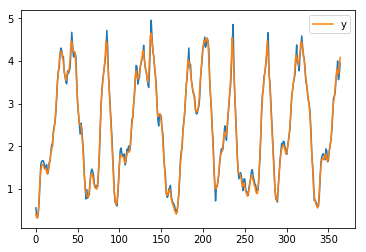

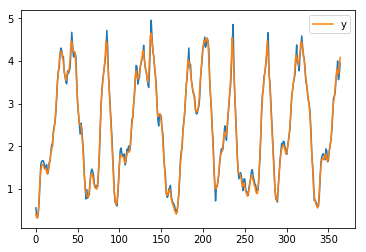

In [30]:
model_fit.plot_predict(start=1, end=365)

In [ ]:
#residuals = pd.DataFrame(residuals)
#residuals.hist()
#series = dataToPlot.iloc[:,2]
#X = series.values
#stationary = difference(X, months_in_year)
#stationary.index = series.index[months_in_year:]
#stationary.plot()
#plt.show()

In [ ]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
series = dataToPlot.iloc[:,1]
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(dataToPlot.iloc[:,2],freq=400)
decompSeasonal = decomposition.seasonal
ax = decompSeasonal.plot(figsize=(14,2))

In [ ]:
decompTrend = decomposition.trend
ax = decompTrend.plot(figsize=(14,2))

In [ ]:
decompResid = decomposition.resid
ax = decompResid.plot(figsize=(14,2))

# PCA

### Explained variance for PCA do determine components

In [32]:
sc = StandardScaler()  
x_trainStd = sc.fit_transform(x_train)  
x_testStd = sc.transform(x_test)  


In [33]:
pca = PCA()
pca.fit_transform(x_trainStd)

array([[-1.92939718e+00, -2.80866044e+00,  3.41265425e-01, ...,
         1.43345693e-03, -1.86915602e-04, -1.99200833e-04],
       [-2.00231195e+00, -2.81463381e+00,  4.12137564e-01, ...,
         1.53799942e-03, -9.97152649e-06, -3.23231436e-04],
       [-1.83117926e+00, -2.68973331e+00,  4.64122339e-01, ...,
         1.26282454e-03, -3.95182869e-04,  4.70170533e-04],
       ...,
       [-6.18643527e-01, -2.31395449e+00,  4.28447482e-01, ...,
        -1.14340588e-04, -1.33434247e-04, -7.33758493e-04],
       [-6.89891974e-01, -2.33737328e+00,  4.52157513e-01, ...,
         2.24202198e-04, -1.11890223e-04, -2.84056756e-04],
       [-7.68130502e-01, -2.36041586e+00,  6.62650856e-01, ...,
        -5.99375241e-04,  8.96289928e-07,  1.69421992e-04]])

Text(0,0.5,'explained_variance_')

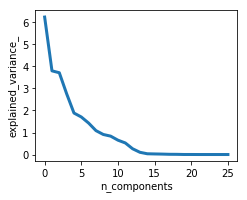

In [34]:
plt.figure(1, figsize=(4, 3))
plt.axes([.1, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

[2.40050674e-01 1.46129083e-01 1.42823519e-01 1.06138935e-01
 7.24519956e-02 6.55533927e-02 5.48966049e-02 4.17322990e-02
 3.49968787e-02 3.21105505e-02 2.50384060e-02 2.02226950e-02
 1.00454816e-02 3.87598078e-03 1.31346910e-03 1.01375618e-03
 7.52558862e-04 3.95749042e-04 3.24796269e-04 6.61487711e-05
 5.69960484e-05 7.21826291e-06 2.74056185e-06 4.90683344e-08
 1.19255059e-08 1.05190304e-08]


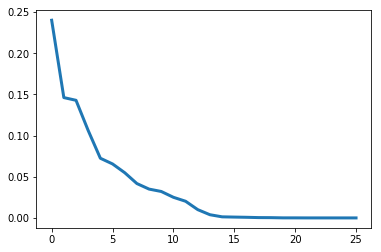

In [58]:
# 11 components 
print(pca.explained_variance_ratio_) 
plt.plot(pca.explained_variance_ratio_, linewidth=3)

Text(0.5,0,'PCA features')

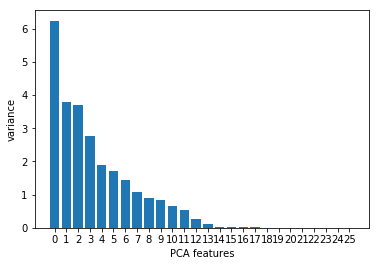

In [36]:
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA features')

In [37]:
# Data Normalization

In [38]:
finalPCA = PCA(n_components= 12)
finalPCA.fit(x_trainStd)
newTrain=  finalPCA.transform(x_trainStd)
reconstruct = finalPCA.inverse_transform(newTrain)
residual = x_trainStd - reconstruct
#residual = x_testStd - reconstruct
residual
thrsOutlier = 1.5
i=-1
for comp in residual:
    i=0
    for value in comp:
        i = i +1
        if value >= thrsOutlier:
            print(value)
            print(i)
            print('this should be removed')
            WithoutAnormaliesTraining = x_train.drop(x_train.index[[i]])

1.5082527901700211
20
this should be removed
1.6014952004688308
20
this should be removed
1.6534949851902392
20
this should be removed
1.7348244274362998
20
this should be removed
1.7611710726783103
20
this should be removed
1.510335872311922
24
this should be removed
2.6354080061740497
24
this should be removed
1.8289453882654858
20
this should be removed
1.5961956698798232
20
this should be removed
1.6187163713667247
24
this should be removed
2.2560113284259504
24
this should be removed
1.5382964328964868
20
this should be removed
1.6236206426597843
20
this should be removed
1.7404273760637652
20
this should be removed
1.6642884703114342
20
this should be removed
1.616190575091685
20
this should be removed
1.6386839915840903
20
this should be removed
1.6048972453589019
20
this should be removed
1.801846871270737
20
this should be removed
1.7733895971227012
20
this should be removed


In [39]:
sc = StandardScaler()  
NoAnormaliesTraining = sc.fit_transform(x_train)  
x_testStd = sc.transform(x_test)  


finalPCA = PCA(n_components= 12)
finalPCA.fit(WithoutAnormaliesTraining)
newTrain=  finalPCA.transform(WithoutAnormaliesTraining)
reconstruct = finalPCA.inverse_transform(newTrain)
residual = WithoutAnormaliesTraining - reconstruct
#residual = x_testStd - reconstruct
residual

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,F_PU4,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
DATETIME,,,,,,,,,,,,,,,,,,,,,
2014-01-06 00:00:00,-0.669515,-0.394097,-0.654652,-0.521079,-0.601152,-0.083462,-0.898624,-0.332168,-0.104226,0.089723,...,0.091407,-0.170072,0.093332,-0.081743,-0.014942,0.318322,-0.014346,0.209273,-0.116729,0.115381
2014-01-06 01:00:00,-0.375178,-0.356009,-0.559886,-0.590629,-0.255736,0.162455,-0.334685,-0.052312,-0.021046,-0.010991,...,0.078909,0.034440,0.079655,0.022138,0.153770,-0.003958,0.153697,0.063387,-0.183207,0.089573
2014-01-06 02:00:00,-0.316405,-0.225872,-0.567076,-0.237188,-0.339655,0.006718,-1.039316,-0.283131,-0.084980,0.072581,...,0.061696,-0.146733,0.060653,-0.092645,-0.094689,0.226115,-0.092278,0.261594,-0.112014,0.078159
2014-01-06 03:00:00,-0.083803,-0.118354,-0.521670,0.116474,-0.106281,-0.051150,-0.618617,-0.091497,-0.023902,-0.013942,...,0.027865,0.024835,0.025491,-0.043196,0.059860,-0.034280,0.062082,0.158171,-0.302104,0.040769
2014-01-06 04:00:00,0.166399,-0.071859,-0.279802,0.597163,-0.274846,-0.006381,0.690042,0.337739,0.103953,-0.137879,...,-0.008682,0.288753,-0.011300,0.060685,0.350692,-0.122848,0.351489,-0.207957,-0.438626,-0.015758
2014-01-06 05:00:00,-0.481031,-0.339068,-0.166103,0.026252,0.442105,0.100389,0.258359,-0.750619,-0.221864,0.137069,...,0.096011,-0.259285,0.097411,-0.129298,-0.556944,0.306978,-0.556811,-0.039748,0.323548,0.125936
2014-01-06 06:00:00,-0.138981,0.296949,-0.122006,-0.570721,0.268896,-0.148758,-0.491985,-0.578032,-0.170862,0.115812,...,-0.049869,-0.266681,-0.049379,-0.098130,-0.480374,0.263374,-0.479127,0.167042,0.124262,-0.045862
2014-01-06 07:00:00,-0.141447,0.223725,0.198549,-0.003803,-0.635158,-0.089815,0.446551,0.308692,0.084628,-0.051150,...,-0.078228,0.097532,-0.078178,0.062279,0.337678,0.073882,0.335861,-0.161141,-0.198539,-0.094831
2014-01-06 08:00:00,0.015564,0.203459,-0.048420,0.128750,-0.528923,0.156736,0.638105,0.808647,0.229206,-0.210939,...,-0.094798,0.419404,-0.092158,0.173780,0.784667,-0.395713,0.781970,-0.230855,-0.373160,-0.134786


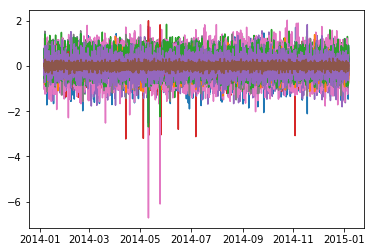

In [40]:
plt.plot(residual)

# BONUS TASK

In [41]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [42]:
# load dataset
dataset = dataToPlot
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
reframed = pd.DataFrame(reframed)
y_train = reframed.iloc[:,-1]
x_train = reframed.iloc[:,:-1]

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041663   0.326844   0.120893   0.294027   0.461055   0.728797   
2   0.020317   0.319408   0.297909   0.308547   0.651667   0.992383   
3   0.000000   0.315129   0.493043   0.466649   0.827433   1.000000   
4   0.002805   0.319432   0.702160   0.648073   0.970192   1.000000   
5   0.035899   0.334301   0.923501   0.895404   0.801508   1.000000   

   var7(t-1)  var8(t-1)  var9(t-1)  var17(t-1)    ...     var18(t)  var19(t)  \
1   0.128789   0.362889   0.988791    0.441344    ...     0.815632  0.443421   
2   0.202221   0.365508   0.989764    0.441076    ...     0.869401  0.443424   
3   0.302105   0.347369   0.983022    0.441442    ...     0.920844  0.450190   
4   0.544778   0.324640   0.974574    0.448463    ...     0.983675  0.461483   
5   0.858088   0.318617   0.972335    0.460010    ...     0.394270  0.822491   

   var20(t)  var21(t)  var22(t)  var23(t)  var24(t)  var25(t)  var26(t)  \
1  0.608323  0.18

In [43]:
# load dataset
dataset = dataToPlot2
y_test
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
reframed = pd.DataFrame(reframed)
x_test = reframed.iloc[:,:-1]
y_test =  reframed.iloc[:,-1]


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.391867   0.919776   0.121569   0.784173   0.550000   1.000000   
2   0.432532   0.787313   0.125490   0.812950   0.703571   0.917809   
3   0.515712   0.625000   0.305882   0.823741   0.910714   0.520548   
4   0.609981   0.509328   0.505882   0.762590   0.800000   0.287672   
5   0.695009   0.442164   0.725490   0.460432   0.639286   0.849315   

   var7(t-1)  var8(t-1)  var9(t-1)  var17(t-1)    ...     var18(t)  var19(t)  \
1   0.866521   0.654035   0.937250    0.595142    ...     0.752169  0.337162   
2   0.897155   0.603586   0.895016    0.334008    ...     0.806317  0.300000   
3   0.610503   0.609205   0.899620    0.296896    ...     0.899688  0.516216   
4   0.431072   0.587926   0.881906    0.510121    ...     0.904200  0.493243   
5   0.663020   0.574895   0.870997    0.487854    ...     0.898299  0.214865   

   var20(t)  var21(t)  var22(t)  var23(t)  var24(t)  var25(t)  var26(t)  \
1  0.572672  0.27

In [44]:
values = reframed.values

# split into input and outputs
train_X = x_train.values
test_X = x_test.values
test_y = y_test.values
train_y = y_train.values
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 46) (8760,) (4176, 1, 46) (4176,)


In [45]:
from keras.layers import LSTM
from keras.layers import Input
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])) )
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=365, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 8760 samples, validate on 4176 samples
Epoch 1/400
 - 1s - loss: 0.0453 - val_loss: 0.0780
Epoch 2/400
 - 0s - loss: 0.0176 - val_loss: 0.0613
Epoch 3/400
 - 0s - loss: 0.0063 - val_loss: 0.0617
Epoch 4/400
 - 0s - loss: 0.0041 - val_loss: 0.0588
Epoch 5/400
 - 0s - loss: 0.0034 - val_loss: 0.0600
Epoch 6/400
 - 0s - loss: 0.0030 - val_loss: 0.0596
Epoch 7/400
 - 0s - loss: 0.0026 - val_loss: 0.0568
Epoch 8/400
 - 0s - loss: 0.0024 - val_loss: 0.0559
Epoch 9/400
 - 0s - loss: 0.0025 - val_loss: 0.0558
Epoch 10/400
 - 0s - loss: 0.0023 - val_loss: 0.0580
Epoch 11/400
 - 0s - loss: 0.0022 - val_loss: 0.0587
Epoch 12/400
 - 0s - loss: 0.0021 - val_loss: 0.0556
Epoch 13/400
 - 0s - loss: 0.0020 - val_loss: 0.0558
Epoch 14/400
 - 0s - loss: 0.0019 - val_loss: 0.0575
Epoch 15/400
 - 0s - loss: 0.0019 - val_loss: 0.0571
Epoch 16/400
 - 0s - loss: 0.0018 - val_loss: 0.0564
Epoch 17/400
 - 0s - loss: 0.0018 - val_loss: 0.0563
Epoch 18/400
 - 0s - loss: 0.0017 - val_loss: 0.0553
Epoch 1

 - 0s - loss: 0.0012 - val_loss: 0.0555
Epoch 154/400
 - 0s - loss: 0.0012 - val_loss: 0.0555
Epoch 155/400
 - 0s - loss: 0.0012 - val_loss: 0.0555
Epoch 156/400
 - 0s - loss: 0.0012 - val_loss: 0.0556
Epoch 157/400
 - 0s - loss: 8.0850e-04 - val_loss: 0.0548
Epoch 158/400
 - 0s - loss: 5.3275e-04 - val_loss: 0.0551
Epoch 159/400
 - 0s - loss: 5.4650e-04 - val_loss: 0.0549
Epoch 160/400
 - 0s - loss: 5.0302e-04 - val_loss: 0.0547
Epoch 161/400
 - 0s - loss: 5.0985e-04 - val_loss: 0.0550
Epoch 162/400
 - 0s - loss: 5.2815e-04 - val_loss: 0.0547
Epoch 163/400
 - 0s - loss: 5.5439e-04 - val_loss: 0.0549
Epoch 164/400
 - 0s - loss: 9.1417e-04 - val_loss: 0.0548
Epoch 165/400
 - 0s - loss: 0.0013 - val_loss: 0.0546
Epoch 166/400
 - 0s - loss: 0.0013 - val_loss: 0.0545
Epoch 167/400
 - 0s - loss: 0.0013 - val_loss: 0.0546
Epoch 168/400
 - 0s - loss: 0.0013 - val_loss: 0.0545
Epoch 169/400
 - 0s - loss: 0.0013 - val_loss: 0.0545
Epoch 170/400
 - 0s - loss: 0.0012 - val_loss: 0.0545
Epoch 171/

 - 0s - loss: 0.0012 - val_loss: 0.0540
Epoch 299/400
 - 0s - loss: 0.0012 - val_loss: 0.0540
Epoch 300/400
 - 0s - loss: 0.0012 - val_loss: 0.0540
Epoch 301/400
 - 0s - loss: 0.0012 - val_loss: 0.0540
Epoch 302/400
 - 0s - loss: 0.0012 - val_loss: 0.0540
Epoch 303/400
 - 0s - loss: 0.0012 - val_loss: 0.0540
Epoch 304/400
 - 0s - loss: 0.0011 - val_loss: 0.0540
Epoch 305/400
 - 0s - loss: 0.0011 - val_loss: 0.0540
Epoch 306/400
 - 0s - loss: 0.0011 - val_loss: 0.0540
Epoch 307/400
 - 0s - loss: 0.0011 - val_loss: 0.0540
Epoch 308/400
 - 0s - loss: 0.0011 - val_loss: 0.0540
Epoch 309/400
 - 0s - loss: 9.4362e-04 - val_loss: 0.0542
Epoch 310/400
 - 0s - loss: 3.9162e-04 - val_loss: 0.0544
Epoch 311/400
 - 0s - loss: 3.0232e-04 - val_loss: 0.0544
Epoch 312/400
 - 0s - loss: 2.9429e-04 - val_loss: 0.0543
Epoch 313/400
 - 0s - loss: 2.6441e-04 - val_loss: 0.0545
Epoch 314/400
 - 0s - loss: 2.6226e-04 - val_loss: 0.0543
Epoch 315/400
 - 0s - loss: 2.8148e-04 - val_loss: 0.0544
Epoch 316/400


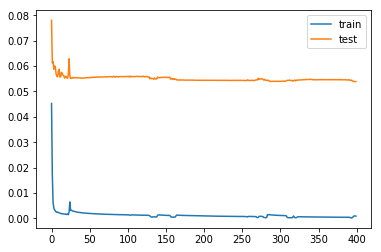

In [47]:
# plot history
#hist = map(lambda x: x-0.054, history.history['val_loss'])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [49]:
history.history

{'loss': [0.04525924652504424,
  0.01758045299599568,
  0.0062623856550393,
  0.004133426380576566,
  0.0033874699535469213,
  0.003015471729061877,
  0.0025762923469301313,
  0.0024097764738447345,
  0.002533309986271585,
  0.0023353819948776313,
  0.002181143994675949,
  0.0021067203294175365,
  0.0019927354781733206,
  0.0018632101564435288,
  0.0019176316612477724,
  0.001803423651532891,
  0.0017819913337007165,
  0.0017407634004484862,
  0.0016812367248348892,
  0.0017217711574630812,
  0.001553392018346737,
  0.0017929492217566196,
  0.0014942978814360686,
  0.0025990677871353305,
  0.006500296343195562,
  0.0031690977969750143,
  0.0032178603093295046,
  0.003059600576913605,
  0.0029036776395514607,
  0.002823585363027329,
  0.002724089650049185,
  0.0026507124809237816,
  0.0025843056306863823,
  0.002529720931003491,
  0.002466006282096108,
  0.0024228048278018832,
  0.002379228671391805,
  0.00233729206956923,
  0.002289586394908838,
  0.0022504939212619015,
  0.00221428599

In [50]:
history.history['val_loss']

[0.07801242911977643,
 0.06125607861538678,
 0.0617475122005065,
 0.05875172193746004,
 0.06001122534017246,
 0.05956181984671777,
 0.056795978696378556,
 0.05594404376572679,
 0.055814639234594676,
 0.0580367275019278,
 0.058687449278135094,
 0.05562736025286153,
 0.05579326891143391,
 0.057484015754278625,
 0.05713422375243207,
 0.05640682618575745,
 0.056257511266856006,
 0.05525883530916457,
 0.05587404183912942,
 0.055917961872182786,
 0.05530930763375687,
 0.05522032815636755,
 0.05652482981874538,
 0.06285849613471178,
 0.05606532542301936,
 0.05507488585012774,
 0.05525813731701663,
 0.055247712366038065,
 0.055497546739482866,
 0.05529803924016758,
 0.05539221194278586,
 0.05543993594399448,
 0.05537603655411867,
 0.055314727459179584,
 0.05536788750110485,
 0.05537442760499662,
 0.05532529522042402,
 0.055329089986360665,
 0.055311412522129955,
 0.05520836239993096,
 0.05522675442542137,
 0.055226161821198494,
 0.05523777860023886,
 0.05526633222640485,
 0.055284449231736824,

In [51]:
test_X.shape

(4176, 1, 46)

In [53]:
from keras.layers import concatenate
from keras.models import Sequential, Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.optimizers import Adagrad

# make a prediction
#test_X =  test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

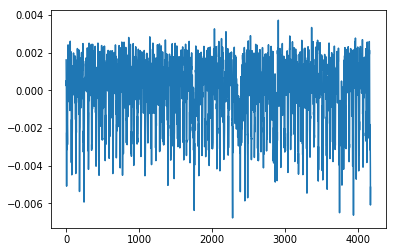

In [54]:
plt.plot(yhat)

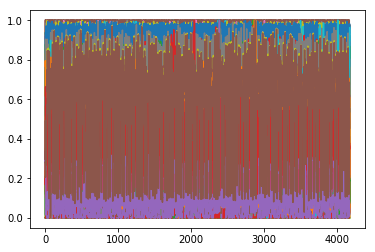

In [55]:
plt.plot(test_X)

In [57]:
# not working 
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)